# CSE 152A Intro to Computer Vision Winter 2022 - Final Project

## Instructor: Prof. Hao Su

- Assignment Published On: **Feb 22 2022**.

- Due On: **March 16 2022 11:59 PM (Pacific Time)**.

## Instructions

- This assignment must be completed **individually**. Discussion on project ideas is allowed. However, you must write down and submit **your own answers** to each question. Sharing identical answers from the group is not allowed and will be seen as plagiarism. 

- You can use any IDE to develop the solutions to this project. You are suggested to use [Google Colab](https://colab.research.google.com/) to program because installing the packages will be a simpler task. You are required to **submit a runnable solution to Gradescope in a zip package if not using Colab**. Otherwise, please submit the .ipynb file.

- You need to **submit a PDF file** to briefly describe your approach and also representative visualizations. Our grading will mainly be based on this PDF file.  We have provided a helper function to create the visualization, but you can be creative in presenting your results (e.g., comparing results from different parameters or methods). 

- You may use other external software packages to solve the components of the problem (e.g., corner detection, feature extraction, etc), but you cannot simply call an existing 3D reconstruction project to directly generate the result. We want you to show your efforts to solve our problem based on what is learned in this quarter.

- If you have any question regarding the final project, please use Piazza or directly send email to TAs. Note that you are **not allowed** to post your detailed answer or code publicly on Piazza.

- It is highly recommended that you begin working on this project early.

**Late Policy:** Assignments will not be accepted after the due date, because Mar 18 is the latest date for the professor to enter grades. 

## 1 Preparation

In our homeworks, we have implemented components of 3D reconstruction from scratch using numpy. However, our implemented versions are basic and not powerful enough to generate high quality results on real images. 

So we suggest that you solve the problem based on the OpenCV library. The original OpenCV version of Colab doesn't have full support of the function that we will be using. To have full support we will need to install OpenCV of version 4.5.4 manually. We will also install a package named pypotree, which is a light-weight 3D visualization package that enables naive visualization on Colab. Run the following commands to install these two packages and restart runtime if needed:

In [2]:
# Install packages that we will use in the project
!pip3 install opencv-contrib-python==4.5.4.60
!pip3 install pypotree

  Using cached pypotree-1.0.5.tar.gz (147 kB)
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for pypotree, since package 'wheel' is not installed.
  Running setup.py install for pypotree ... error
  error: subprocess-exited-with-error
  
  × Running setup.py install for pypotree did not run successfully.
  │ exit code: 1
  ╰─> [57 lines of output]
      running install
      running build
      running build_py
      creating build
      creating build/lib
      copying pypotree.py -> build/lib
      running egg_info
      writing pypotree.egg-info/PKG-INFO
      writing dependency_links to pypotree.egg-info/dependency_links.txt
      writing requirements to pypotree.egg-info/requires.txt
      writing top-level names to pypotree.egg-info/top_level.txt
      reading manifest file 'pypotree.egg-info/SOURCES.txt'
      reading manifest template 'MANIFEST.in'
      writing manifest file 'pypotree.egg-info/SOURCES.txt'
      git clone https://github.com/cmla/Potre

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pypotree

Below are some useful helper functions derived from previous homeworks that help us convert between Euclidean coordinates and homogeneous coordinates and help us visualize correspondences.

In [ ]:
# Helper functions
def to_homog(points):
    """
    Function: convert points from Euclidean coordinates to homogeneous coordinates
    points: 3xn numpy array containing Euclidean coordinates
    Return: 4xn numpy array containing homogeneous coordinates
    """
    m, n = points.shape
    points_homog = np.concatenate([points, np.ones([1, n])], axis=0)
    return points_homog

def from_homog(points_homog):
    """
    Function: convert points from homogeneous coordinates to Eulidean coordinates
    points_homog: 4xn numpy array containing homogeneous coordinates
    Return: 3xn numpy array containing Euclidean coordinates
    """
    m, n = points_homog.shape
    points = points_homog[:m-1] / points_homog[m-1]
    return points

def hstack_images(img1, img2):
    """
    Function: stacks 2 images side-by-side
    img1, img2: two input images
    Return: stacked image
    """
    H = max(img1.shape[0], img2.shape[0])
    W = img1.shape[1] + img2.shape[1]
    img = np.zeros((H, W, 3), dtype=img1.dtype)
    img[:img1.shape[0], :img1.shape[1], :] = img1
    img[:img2.shape[0], img1.shape[1]:, :] = img2
    return img

def vis_correspondence(img1, img2, S1, S2):
    """
    Function: visualizes corresponding points between two images
    img1, img2: two input images
    S1: 2xn numpy array containing points in image 1
    S2: 2xn numpy array containing points in image 2 that corresponds to points in image 1
    """
    img = hstack_images(img1, img2)
    x_shift = img1.shape[1]
    S1 = S1.astype(np.int)  # Shape: [2, n].
    S2 = S2.astype(np.int)  # Shape: [2, n].
    np.random.seed(0)
    colors = np.random.rand(S1.shape[1], 3)
    if img.dtype == np.uint8:
      colors *= 255

    # Draw figure. 
    for p1, p2, color in zip(S1.T, S2.T, colors):
      x1, y1 = p1
      x2, y2 = p2
      img = cv.circle(img, (x1, y1), 5, color, -1)
      img = cv.circle(img, (x2 + x_shift, y2), 5, color, -1)
      img = cv.line(img, (x1, y1), (x2 + x_shift, y2), color, 2, cv.LINE_AA)
    plt.figure(figsize=(16, 12))
    plt.title('Visualize correspondences')
    plt.imshow(img)
    plt.show()

Then we load the data set into our runtime. 

Add the contents from the zip folder "final_project_data.zip", available in canvas -> files, into this colab notebook, and run the following code. You should be able to visualize all the images in a grid.

In [ ]:
# Load images into a list
images = []
for i in range(49):
    image = cv.imread(f'./final_project_data/images/{i}.jpg') # Use cv.imread instead of plt.imread so that we can directly use cv functions afterwards
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # cv.imread save data in BGR order by default, change it into RGB
    images.append(image)

# Preview of images
fig = plt.figure(figsize=(25, 25))
row = 7
col = 7
for i in range(row * col):
    ax = fig.add_subplot(row, col, i+1)
    ax.title.set_text(f'Image {i}')
    plt.imshow(images[i])
plt.show()

In [ ]:
# Load intrinsic and extrinsic matrices
intrinsics = np.load('./final_project_data/intrinsics.npy')
extrinsics = np.load('./final_project_data/extrinsics.npy')

## 2 Identify Points of Interests
The very first step of 3D reconstruction is to identify points of interests in images. In homework we build a Shi-Tomasi corner detector which is able to detect corner points in images. In this approach we will use a stronger dectection algorithm called SIFT provided by OpenCV. The basic idea of SIFT is similar to Shi-Tomasi, instead while Shi-Tomasi is rotation-invariant (which means even if the image is rotated we can still find the same corners), SIFT is rotation-invariant and scaling-invariant (even if the image is scaled the same corners can still be found). For more information and usages, refer to [https://docs.opencv.org/4.5.4/da/df5/tutorial_py_sift_intro.html](https://docs.opencv.org/4.5.4/da/df5/tutorial_py_sift_intro.html).

In [ ]:
# Use SIFT to detect key points in images and compute descriptors for those key points
# You may need the help of cv.SIFT_create(), detectAndCompute(), and cv.drawKeypoints()

keypoints = []
descriptors = []
outputs = []    

for i, image in enumerate(images):
    gray_image = cv.cvtColor(image,cv.COLOR_RGB2GRAY) # Convert image to grayscale
    # Fill in codes to detect corners
    
# Preview of images. You can use cv.drawKeypoints to generate the images with corners and visualize by plt.imshow()
fig = plt.figure(figsize=(25, 25))
row = 7
col = 7
for i in range(row * col):
    ax = fig.add_subplot(row, col, i+1)
    ax.title.set_text(f'Image {i}')
    plt.imshow(outputs[i])
plt.show()

## 3 3D Reconstruction with Two Cameras

After getting key points of our image set we can formally start to build reconstruction. To begin with, let's first try to build the reconstruction with two images. We want to choose two images from our image set, derive the correspondences between their keypoints, and do triangulation according to the extrinsic/intrinsic matrices and correspondes to reconstruct 3D points. Since every two neighboring images in our dataset are also photoed by neighboring cameras, we can start with image 0 and image 1. We add images one by one later.

To derive correspondence between two images, we will have to select a feature descriptor and use it to compare the distance between any two pairs of key points across two images. In lectures we introduced SSD and NCC. In the previous section we've already derived descriptors for key points returned by SIFT, which are much stronger descriptors than SSD and NCC. We'll be passing it to OpenCV's matching algorithm in this section. [https://docs.opencv.org/4.5.4/dc/dc3/tutorial_py_matcher.html](https://docs.opencv.org/4.5.4/dc/dc3/tutorial_py_matcher.html) has a nice tutorial of how to achieve this. It also includes a tutorial of how to increase the robustness of the result by adding a ratio test. The parameter of the ratio test can largely affect the result, so it's a good idea to try different parameter.

### 3.1 Search for Corresponding Points across two images

In [ ]:
# you may need functions cv.BFMatcher and knnMatch to compare against features. 
# You may need to understand the output data structure of detectAndCompute() function
# for the SIFT feature extractor. If you are able to understand the description, 
# you should be able to know what kp1, kp2, des1, des2 should be.
def get_corresondence(img1, img2, kp1, kp2, des1, des2):
    """
    Function: get correspondence across two images
    img1, img2: two input images
    kp1, kp2: keypoints of img1 and img2
    des1, des2: descriptors of img1 and img2
    Return: two 2xn numpy array that contains corresponding points after validation
    """
    # Fill in the code here
    return pts1, pts2

In [ ]:
# Get corresondence of image 0 and image 1
pts1, pts2 = get_corresondence(images[0], images[1], keypoints[0], keypoints[1], descriptors[0], descriptors[1])

# Visualize correspondence
vis_correspondence(images[0], images[1], pts1, pts2)
print("Number of correspondences derived: %d" % (len(pts1[0])))

### 3.2 Triangulation

After that, we can use the correspondence to reconstruct 3D points through triangulation. You can use the optimization approach that we've introduced in class, but a simpler approach is to use a function called `triangulatePoints` in OpenCV library to achieve this. `triangulatePoints` takes in four parameters, which are the two projection matrices (camera matrices) and the two corresponding points arrays. All we have to do here is to calculate the projection matrices via intrinsic and extrinsic matrices, and pass it together with the correspendence we derived to `triangulatePoints`. 

*Notice: `triangulatePoints` returns coordinates in homogeneous coordinates. For further visualization you would have to convert it back into Euclidean coordinates.*

In [ ]:
def reconstruct(pts1, pts2, int1, int2, ext1, ext2):
    """
    Function: reconstruct 3D points with given correspondence
    int1, int2: intrinsic matrices of camera 1 and camera 2
    ext1, ext2: extrinsic matrices of camera 1 and camera 2
    Return: 3xn numpy arrays containing the Euclidean coordinates of reconstructed 3D points
    """
    # Fill in the code here

    return recon

In [ ]:
# Reconstruct 3D points
recon = reconstruct(pts1, pts2, intrinsics[0], intrinsics[1], extrinsics[0], extrinsics[1])

Let's see the visualization of our results using pypotree:

In [ ]:
# Visualizing reconstruction results
cloudpath = pypotree.generate_cloud_for_display(-recon.T) # pypotree takes in nx3 numpy array, add negative to reverse axis
pypotree.display_cloud_colab(cloudpath)

## 4 3D Reconstruction with Multiple Cameras

### 4.1 Validate Correspondence

Before adding more images into scope, let's first take a look at validating the correspondence. The plain correspondence we derived above might include some noises. This might not be obvious when we are only building the reconstruction with two images, but as we increase our data set size, the error will accumulate and bring a large number of false correspondence. A good idea is to use fundamental matrix to remove outliers. We can use the approach we've implemented in HW4. However, here we don't have to use RANSAC as we already have the intrinsic and extrinsic matrices of the cameras, which enables us to derive the ground-truth fundamental matrix. All we have to do is to get the fundamental matrix with given intrinsic and extrinsic matrix, and then use it to remove outliers without iterations. The formula for calculating fundamental matrix is
$$F = K_1^{-T}([t]_{\times}R)K_2^{-1}$$
where
$$
[t]_{\times} = 
\begin{bmatrix}
0 & -t_3 & t_2 \\
t_3 & 0 & -t_1 \\
-t_2 & t_1 & 0
\end{bmatrix}
$$
A good starting point of setting threshold that determines whether a point is outlier or not is 1% of the image's width or height.

In [ ]:
def validate_correspondence(pts1, pts2, int1, int2, ext1, ext2):
    """
    Function: validate corespondence via fundamental matrix
    pts1, pts2: two 2xn numpy arrays containing the original correspondence
    int1, int2: intrinsic matrices of camera 1 and camera 2
    ext1, ext2: extrinsic matrices of camera 1 and camera 2
    Return: two 2xn numpy array that contains corresponding points after validation
    """
    # Caculate fundamental matrix from camera matrices
    # Fill in the code here

    # Remove outliers with fundamental matrix
    # Fill in the code here

    return pts1_inliers, pts2_inliers

In [ ]:
# Validate correspondence via camera matrices
pts1_inliers, pts2_inliers = validate_correspondence(pts1, pts2, intrinsics[0], intrinsics[1], extrinsics[0], extrinsics[1])

# Visualize correspondence after validation
print("Correspondence after validation:")
vis_correspondence(images[0], images[1], pts1_inliers, pts2_inliers)
print("Number of correspondences after validation: %d" % (len(pts1_inliers[0])))

The smaller the threshold, the fewer correspondences are preserved. While decreasing the threshold enable us to remove noises, it might also remove some correct correspondence. Let's use our cleaned correspondence to do reconstruction and visualize it again:

In [ ]:
# Reconstruct 3D points with cleaner visualization
recon = reconstruct(pts1_inliers, pts2_inliers, intrinsics[0], intrinsics[1], extrinsics[0], extrinsics[1])

# Visualizing reconstruction results
cloudpath2 = pypotree.generate_cloud_for_display(-recon.T)
pypotree.display_cloud_colab(cloudpath2)

Depends on how small the threshold you've set, you might observe a much sparser result than before, which barely gives the outline of the object. Although this doesn't look like optimizing, it will gives us better result when we increase the data set size.

### 4.2 Adding More Cameras

The idea of including more cameras is simple: since every two neighboring images are photoed by neighboring cameras, which means it is possible to get a fair correspondence between every two neighboring images, we can do a sequence of matching-validating-triangulating on every pair of neighboring images (image 0 and 1, 1 and 2, 2 and 3, etc.) and put all of the points we calculated together. Since we have 49 images, which gives us 50 neighboring pairs, it is fair to expect getting over 10x reconstructed points than only using two images. The threshold in `validate_correspondence` will affect the results a lot. Calculating points for the whole dataset takes around 5 min, so it's a good idea to add images batches by batches and test how will the paramaters affect the results.

In [ ]:
# Include the whole data set
for i in range (1, 48):
    print("Resconstructing from image %d and %d..." % (i, i+1))
    pts1, pts2 = get_corresondence(images[i], images[i+1], keypoints[i], keypoints[i+1], descriptors[i], descriptors[i+1])
    pts1_inliers, pts2_inliers = validate_correspondence(pts1, pts2, intrinsics[i], intrinsics[i+1], extrinsics[i], extrinsics[i+1])
    recon_next = reconstruct(pts1_inliers, pts2_inliers, intrinsics[i], intrinsics[1+1], extrinsics[i], extrinsics[i+1])
    recon = np.hstack([recon, recon_next])

In [ ]:
# Visualizing reconstruction results
cloudpath3 = pypotree.generate_cloud_for_display(-recon.T)
pypotree.display_cloud_colab(cloudpath3)

There are quite a lot outliers, which give space for further optimization, but by maginifying we are able to see the outline of the object.

## 5 Further Opimization

The tutorial here may be helpful: http://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html

Be creative in this part!

# 6 Reference result 

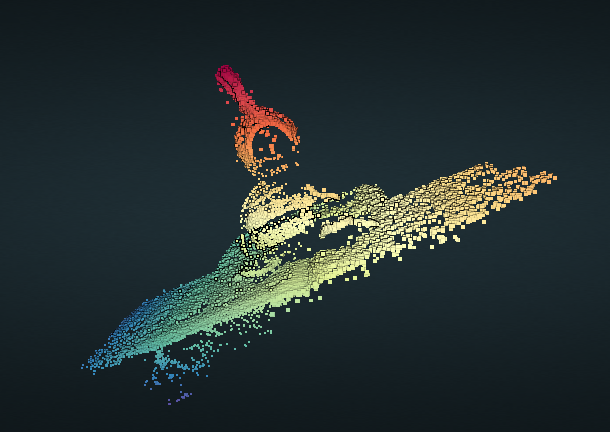